In [1]:
# Importing Necessary Libraries
import tensorflow
import seaborn
import google
import random
import os
import PIL
import pandas
import matplotlib
import numpy
import scipy.io.wavfile as wavefile
import shutil
import csv
import zipfile
import librosa
from librosa import display
import sklearn 
from tqdm.notebook import tqdm
!pip install soundfile
import soundfile
from IPython.display import Audio

In [2]:
# Kaggle API Authentication
!pip install -q kaggle
google.colab.files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [15]:
# Downloading and Unzipping Dataset
!kaggle datasets download -d vbookshelf/respiratory-sound-database
!unzip -q respiratory-sound-database.zip

100% 3.68G/3.69G [01:09<00:00, 36.5MB/s]
100% 3.69G/3.69G [01:10<00:00, 56.5MB/s]


In [16]:
# Initializing Patient Data
patient_data = pandas.read_csv("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv", names = ["Patient ID", "Diagnosis"])   
patient_data.head() 

,Patient ID,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [17]:
def get_file_information(filename): 
  return filename.split("_")  

In [18]:
# Initializing Signal Data 
filenames = [filename.split(".")[0] for filename in os.listdir("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files") if ".txt" in filename]
collected_data = []

for filename in tqdm(filenames):
  data = pandas.read_csv("/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/" + filename + ".txt", sep = "\t", names = ["Start", "End", "Crackles", "Wheezes"])
  file_information = get_file_information(filename)
  data["Patient ID"] = file_information[0]
  data["Audio Type"] = file_information[-2]
  data["Filename"] = filename
  collected_data.append(data)

signal_data = pandas.concat(collected_data)
signal_data.reset_index()
signal_data.head()

,Start,End,Crackles,Wheezes,Patient ID,Audio Type,Filename
0,1.427,4.466,1,0,170,mc,170_1b3_Pl_mc_AKGC417L
1,4.466,7.237,1,0,170,mc,170_1b3_Pl_mc_AKGC417L
2,7.237,10.125,1,0,170,mc,170_1b3_Pl_mc_AKGC417L
3,10.125,13.130,1,0,170,mc,170_1b3_Pl_mc_AKGC417L
4,13.130,16.302,1,0,170,mc,170_1b3_Pl_mc_AKGC417L


In [19]:
# Examining Data Type Of Patient Data 
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int64 
 1   Diagnosis   126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [20]:
# Examining Data Type Of Signal Data
signal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start       6898 non-null   float64
 1   End         6898 non-null   float64
 2   Crackles    6898 non-null   int64  
 3   Wheezes     6898 non-null   int64  
 4   Patient ID  6898 non-null   object 
 5   Audio Type  6898 non-null   object 
 6   Filename    6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [21]:
# Changing The Data Types Of Patient And Signal Data To Int32 For Merging Compatibility
patient_data["Patient ID"] = patient_data["Patient ID"].astype("int32")
signal_data["Patient ID"] = signal_data["Patient ID"].astype("int32")

In [22]:
# Examining Updated Data Type Of Patient Data
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int32 
 1   Diagnosis   126 non-null    object
dtypes: int32(1), object(1)
memory usage: 1.6+ KB


In [23]:
# Examining Updated Data Type Of Signal Data
signal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start       6898 non-null   float64
 1   End         6898 non-null   float64
 2   Crackles    6898 non-null   int64  
 3   Wheezes     6898 non-null   int64  
 4   Patient ID  6898 non-null   int32  
 5   Audio Type  6898 non-null   object 
 6   Filename    6898 non-null   object 
dtypes: float64(2), int32(1), int64(2), object(2)
memory usage: 404.2+ KB


In [24]:
# Merging Patient and Signal Data
data = pandas.merge(signal_data, patient_data, on = "Patient ID")
data.head()

,Start,End,Crackles,Wheezes,Patient ID,Audio Type,Filename,Diagnosis
0,1.427,4.466,1,0,170,mc,170_1b3_Pl_mc_AKGC417L,COPD
1,4.466,7.237,1,0,170,mc,170_1b3_Pl_mc_AKGC417L,COPD
2,7.237,10.125,1,0,170,mc,170_1b3_Pl_mc_AKGC417L,COPD
3,10.125,13.130,1,0,170,mc,170_1b3_Pl_mc_AKGC417L,COPD
4,13.130,16.302,1,0,170,mc,170_1b3_Pl_mc_AKGC417L,COPD


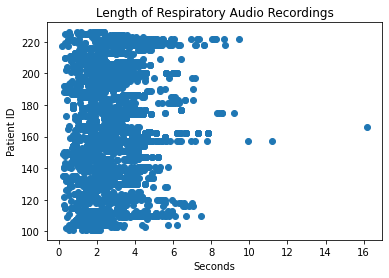

In [25]:
# Examining Recording Length Of Samples
matplotlib.pyplot.figure()
matplotlib.pyplot.scatter(x = (data["End"] - data["Start"]), y = data["Patient ID"])
matplotlib.pyplot.xlabel("Seconds")
matplotlib.pyplot.ylabel("Patient ID")
matplotlib.pyplot.title("Length of Respiratory Audio Recordings")
matplotlib.pyplot.show()

In [ ]:
# Defining a Pure Audio Sample Retrieving Function
def get_pure_audio_sample(raw_data, start, end, sample_rate):
  max_index = len(raw_data)
  start_index = min(int(start * sample_rate), max_index)
  end_index = min(int(end * sample_rate), max_index)
  return raw_data[start_index: end_index]

In [26]:
# Creating A Directory For Processed Audio Files
os.mkdir("Processed_Audio_Files")

In [ ]:
# Processing Audio Files
for index, row in tqdm(data.iterrows()):
  max_length = 6
  start = row["Start"]
  end = row["End"]
  filename = row["Filename"]

  if end - start > max_length:
    end = start + max_length
  
   audio_file_path = "/content/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/" + filename + ".wav" 

  if index > 0:
    if data.iloc[index - 1]["Filename"] == filename:
      i += 1 
    else:   
      i = 0

  filename = filename + "_" + str(i) + ".wav"

  save_path = "/content/Processed_Audio_Files/" + filename

  audio, sample_rate = librosa.load(audio_file_path)
  pure_audio = get_pure_audio_sample(raw_audio, start, end, sample_rate) 

  required_length = (sample_rate * 6) 
  padded_audio = librosa.util.pad_center(pure_audio,  required_length)

  soundfile.write(file = save_path, data = padded_audio, samplerate = sample_rate)

In [27]:
# Downloading Processed Audio Files
with zipfile.ZipFile("/content/drive/MyDrive/Processed_Audio_Files.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Processed_Audio_Files")

In [28]:
def get_patient_id(filename):
  return filename.split("_")[0]

In [29]:
# Initializing File Data
path = "/content/Processed_Audio_Files"
length = len(os.listdir(path))
index = range(length)
i = 0 

files = pandas.DataFrame(index = index, columns = ["Patient ID", "Filename"])

for filename in tqdm(os.listdir(path)):
  files.iloc[i]["Patient ID"] = get_patient_id(filename)
  files.iloc[i]["Filename"] = filename
  i += 1

files.head()

,Patient ID,Filename
0,222,222_1b1_Ar_sc_Meditron_4.wav
1,200,200_2p4_Tc_mc_AKGC417L_2.wav
2,186,186_2b2_Ar_mc_AKGC417L_4.wav
3,170,170_1b3_Al_mc_AKGC417L_3.wav
4,221,221_2b1_Lr_mc_LittC2SE_0.wav


In [18]:
# Examining Data Type Of File Data
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  6898 non-null   object
 1   Filename    6898 non-null   object
dtypes: object(2)
memory usage: 107.9+ KB


In [19]:
# Examining The Data Type Of Patient Data
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int32 
 1   Diagnosis   126 non-null    object
dtypes: int32(1), object(1)
memory usage: 1.6+ KB


In [30]:
# Changing The Data Type Of Files and Patient Data to Int32 for Merging Compatibility
files["Patient ID"] = files["Patient ID"].astype("int32")
patient_data["Patient ID"] = patient_data["Patient ID"].astype("int32")

In [21]:
# Examining The Updated Data Type Of Files Data
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  6898 non-null   int32 
 1   Filename    6898 non-null   object
dtypes: int32(1), object(1)
memory usage: 81.0+ KB


In [22]:
# Examining The Updated Data Type of Patient Data
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient ID  126 non-null    int32 
 1   Diagnosis   126 non-null    object
dtypes: int32(1), object(1)
memory usage: 1.6+ KB


In [31]:
# Merging Files and Patient Data 
dataset = pandas.merge(files, patient_data, on = "Patient ID")
dataset.head()

,Patient ID,Filename,Diagnosis
0,222,222_1b1_Ar_sc_Meditron_4.wav,COPD
1,222,222_1b1_Ar_sc_Meditron_6.wav,COPD
2,222,222_1b1_Pr_sc_Meditron_12.wav,COPD
3,222,222_1b1_Lr_sc_Meditron_5.wav,COPD
4,222,222_1b1_Pr_sc_Meditron_8.wav,COPD


In [32]:
# Dividing The Dataset Into Training and Testing Subsets
from sklearn.model_selection import train_test_split
training_dataset, testing_dataset = train_test_split(dataset, test_size = 0.1, random_state = 42)

In [33]:
training_dataset.head()

,Patient ID,Filename,Diagnosis
1569,130,130_2p5_Ar_mc_AKGC417L_10.wav,COPD
5283,174,174_1p3_Pr_mc_AKGC417L_3.wav,COPD
6640,166,166_1p1_Ar_sc_Meditron_2.wav,COPD
1789,130,130_2p5_Pl_mc_AKGC417L_6.wav,COPD
4239,209,209_1b1_Tc_sc_Meditron_1.wav,Healthy


In [34]:
testing_dataset.head()

,Patient ID,Filename,Diagnosis
2908,219,219_2b3_Tc_mc_LittC2SE_3.wav,Pneumonia
2666,207,207_2b2_Ar_mc_AKGC417L_3.wav,COPD
5809,195,195_1b1_Ll_sc_Litt3200_8.wav,COPD
5832,195,195_1b1_Ar_sc_Litt3200_15.wav,COPD
3710,133,133_3p2_Pl_mc_AKGC417L_1.wav,COPD


In [35]:
# Examining The Training Dataset Class Distribution
print("Training Dataset Class Distribution:\n\n{}".format(training_dataset["Diagnosis"].value_counts()))

Training Dataset Class Distribution:

COPD              5166
Healthy            292
Pneumonia          256
URTI               225
Bronchiolitis      143
Bronchiectasis      93
LRTI                28
Asthma               5
Name: Diagnosis, dtype: int64


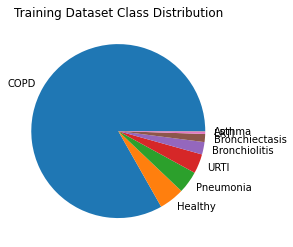

In [36]:
# Visualizing The Training Dataset Class Distribution  
matplotlib.pyplot.figure() 
matplotlib.pyplot.pie(training_dataset["Diagnosis"].value_counts(), labels = ["COPD", "Healthy", "Pneumonia", "URTI", "Bronchiolitis", "Bronchiectasis", "LRTI", "Asthma"])
matplotlib.pyplot.title("Training Dataset Class Distribution")
matplotlib.pyplot.show()

In [29]:
# Resampling The Training Dataset 
copd_samples = training_dataset[training_dataset["Diagnosis"] == "COPD"].sample(n = 1000, random_state = 42)
healthy_samples = training_dataset[training_dataset["Diagnosis"] == "Healthy"]
pneumonia_samples = training_dataset[training_dataset["Diagnosis"] == "Pneumonia"] 
urti_samples = training_dataset[training_dataset["Diagnosis"] == "URTI"]  
bronchiolitis_samples = training_dataset[training_dataset["Diagnosis"] == "Bronchiolitis"]
bronchiectasis_samples = training_dataset[training_dataset["Diagnosis"] == "Bronchiectasis"]

healthy_upsample = sklearn.utils.resample(healthy_samples, replace = True, n_samples = 1000, random_state = 42)
pneumonia_upsample = sklearn.utils.resample(pneumonia_samples, replace = True, n_samples = 1000, random_state = 42)
urti_upsample = sklearn.utils.resample(urti_samples, replace = True, n_samples = 1000, random_state = 42)
bronchiolitis_upsample = sklearn.utils.resample(bronchiolitis_samples, replace = True, n_samples = 1000, random_state = 42)
bronchiectasis_upsample = sklearn.utils.resample(bronchiectasis_samples, replace = True, n_samples = 1000, random_state = 42)


training_dataset = pandas.concat([copd_samples, healthy_upsample, pneumonia_upsample, urti_upsample, bronchiolitis_upsample, bronchiectasis_upsample])

In [30]:
training_dataset.head()

,Patient ID,Filename,Diagnosis
825,130,130_1p3_Lr_mc_AKGC417L_2.wav,COPD
355,186,186_2b2_Pr_mc_AKGC417L_4.wav,COPD
5195,120,120_1b1_Ar_sc_Meditron_16.wav,COPD
1217,130,130_1p2_Al_mc_AKGC417L_4.wav,COPD
2569,172,172_1b5_Lr_mc_AKGC417L_1.wav,COPD


In [31]:
# Examining The Updated Training Dataset Class Distribution
print("Updated Training Dataset Class Distribution:\n\n{}".format(training_dataset["Diagnosis"].value_counts()))

Updated Training Dataset Class Distribution:

URTI              1000
COPD              1000
Pneumonia         1000
Bronchiectasis    1000
Bronchiolitis     1000
Healthy           1000
Name: Diagnosis, dtype: int64


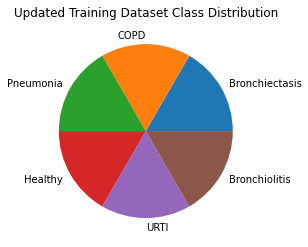

In [32]:
# Visualizing The Updated Training Dataset Class Distribution  
matplotlib.pyplot.figure() 
matplotlib.pyplot.pie(training_dataset["Diagnosis"].value_counts(), labels = ["Bronchiectasis", "COPD", "Pneumonia", "Healthy", "URTI", "Bronchiolitis"])
matplotlib.pyplot.title("Updated Training Dataset Class Distribution")
matplotlib.pyplot.show()

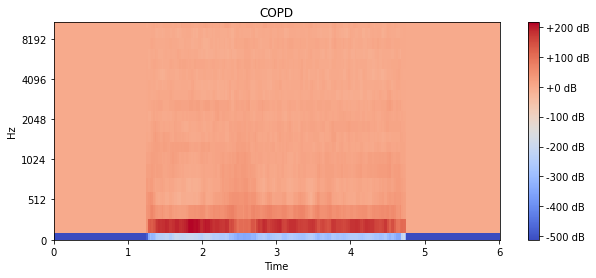

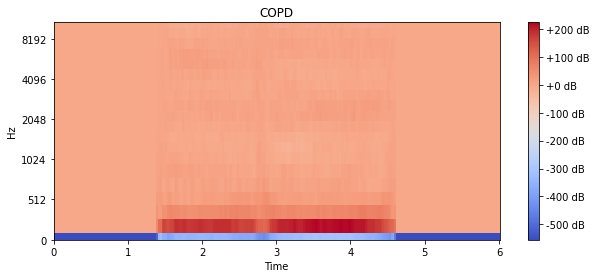

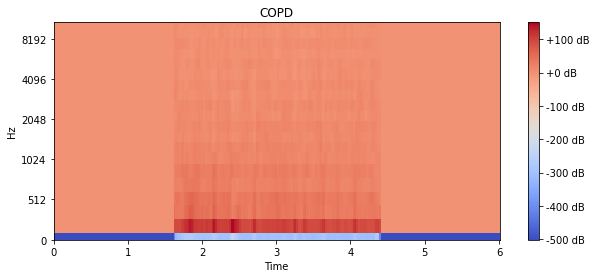

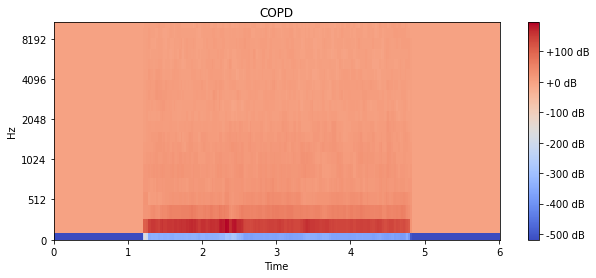

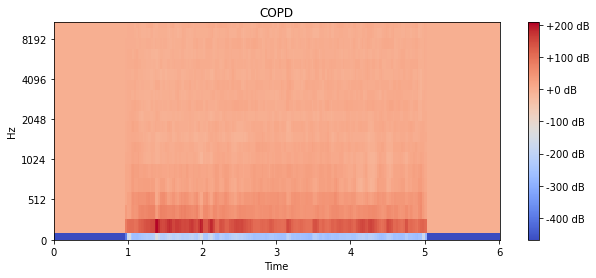

In [33]:
# Visualizing COPD
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[0]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("COPD")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("COPD")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[400]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("COPD")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[600]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("COPD")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[800]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("COPD")
matplotlib.pyplot.show()

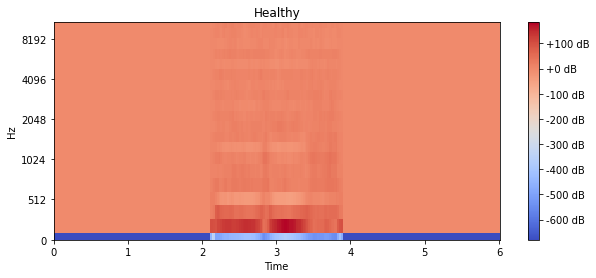

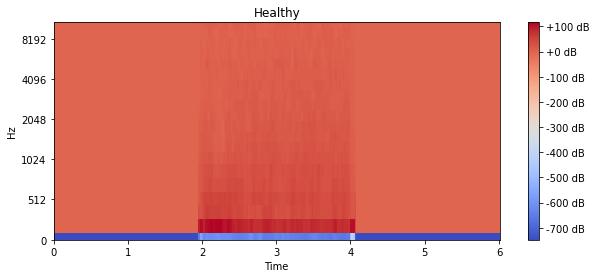

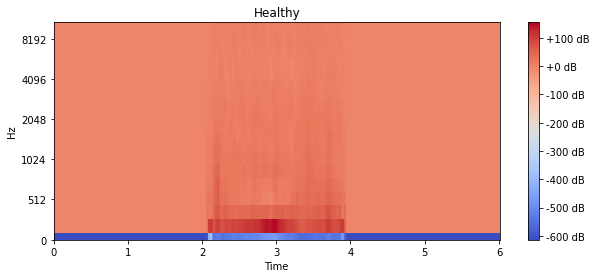

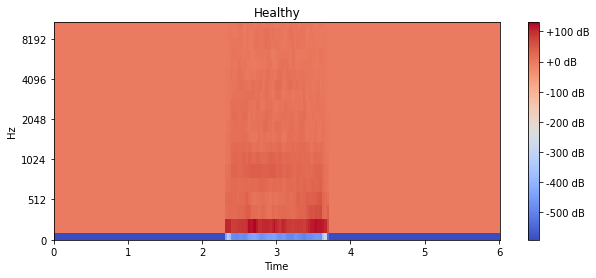

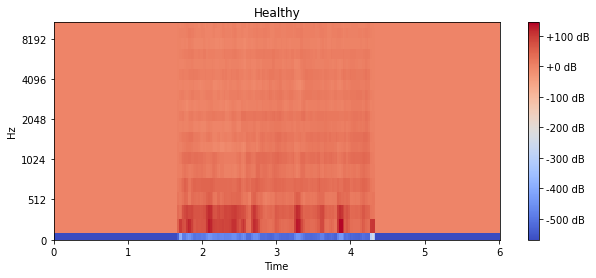

In [34]:
# Visualizing Healthy
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[1000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Healthy")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[1200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Healthy")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[1400]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Healthy")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[1600]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Healthy")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[1800]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Healthy")
matplotlib.pyplot.show()

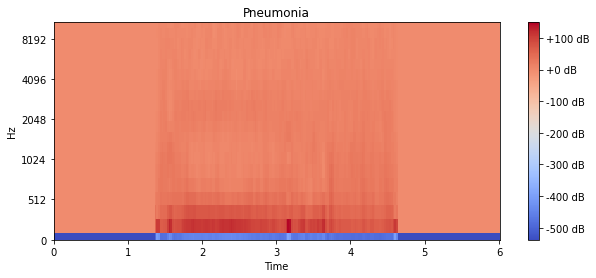

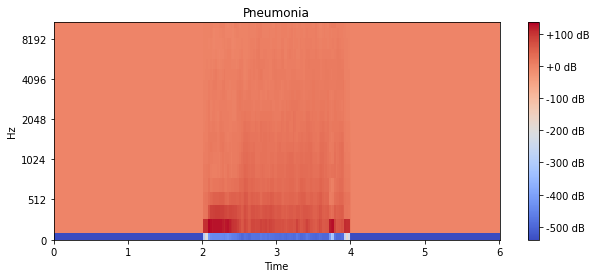

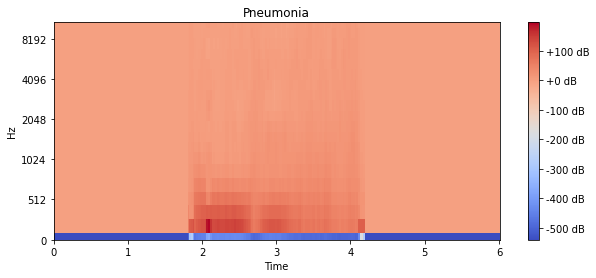

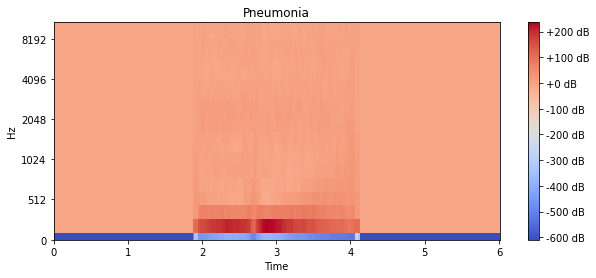

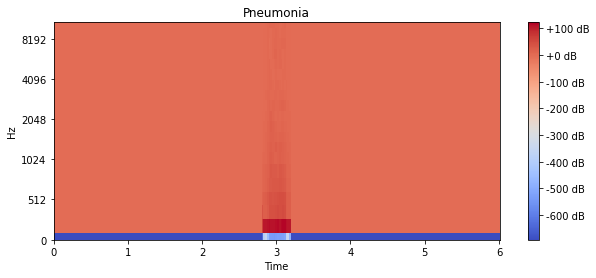

In [35]:
# Visualizing Pneumonia
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[2000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Pneumonia")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[2200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Pneumonia")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[2400]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Pneumonia")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[2600]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Pneumonia")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[2800]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Pneumonia")
matplotlib.pyplot.show()

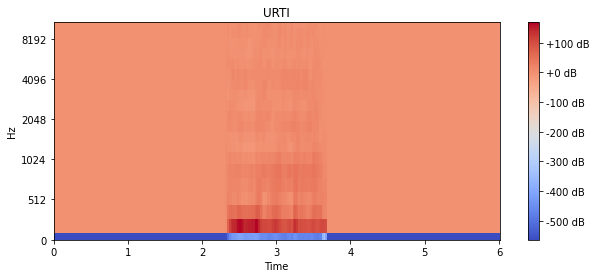

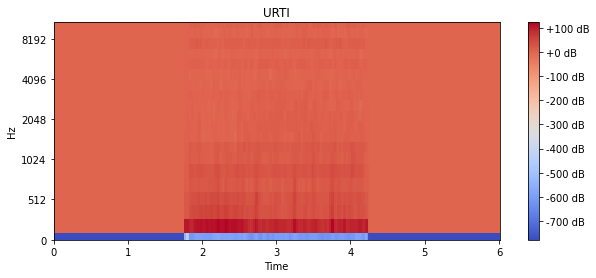

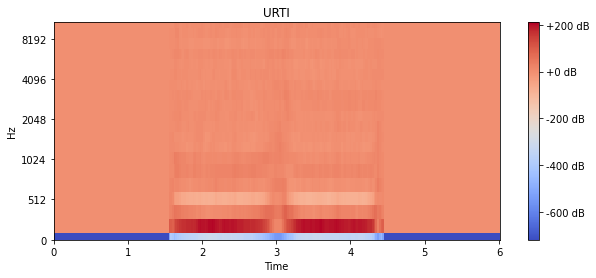

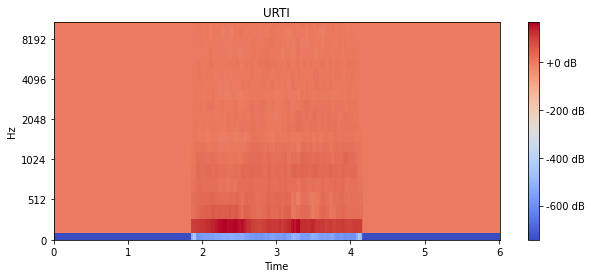

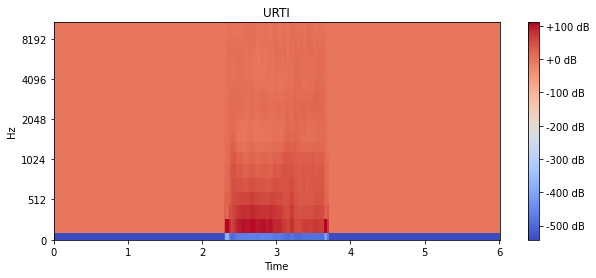

In [36]:
# Visualizing URTI
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[3000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("URTI")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[3200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("URTI")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[3400]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("URTI")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[3600]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("URTI")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[3800]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("URTI")
matplotlib.pyplot.show()

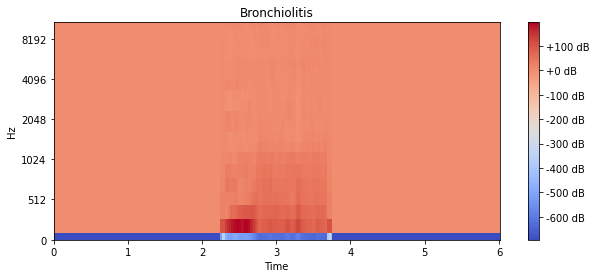

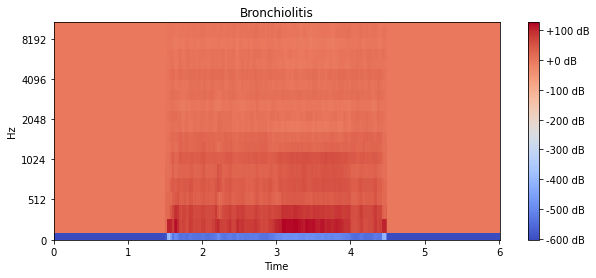

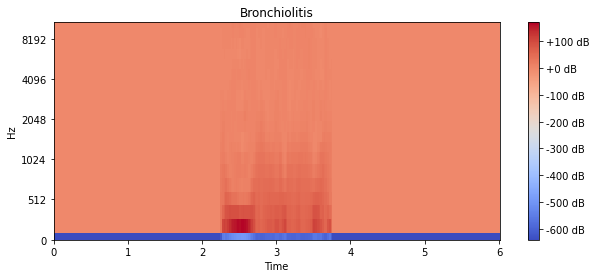

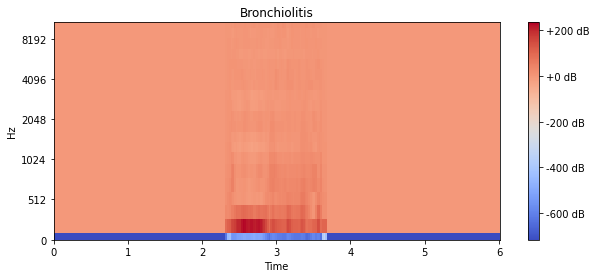

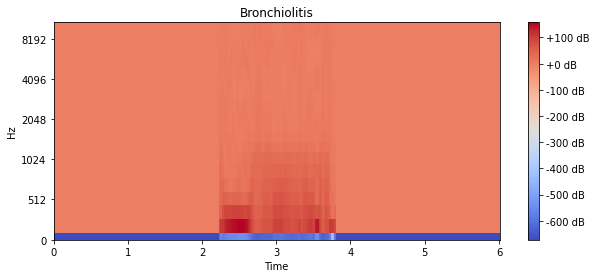

In [37]:
# Visualizing Bronchiolitis
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[4000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiolitis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[4200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiolitis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[4400]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiolitis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[4600]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiolitis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[4800]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiolitis")
matplotlib.pyplot.show()

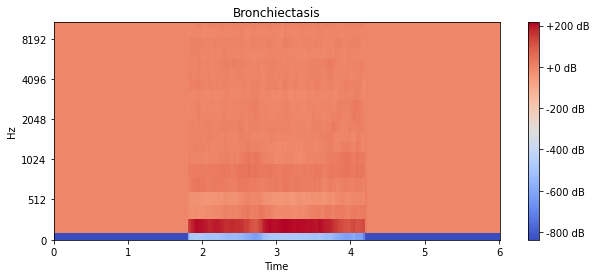

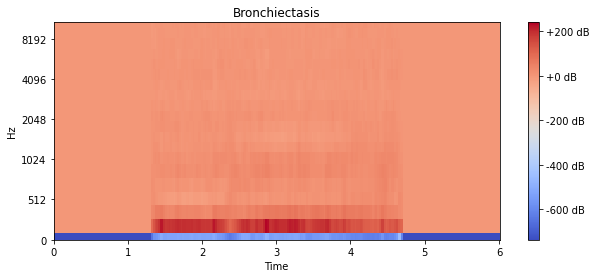

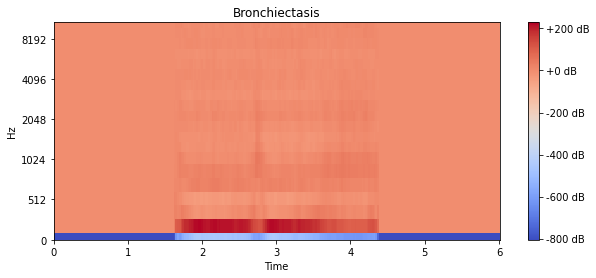

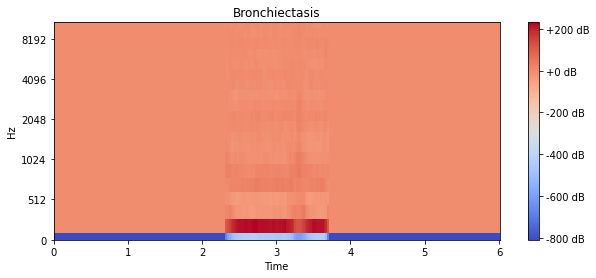

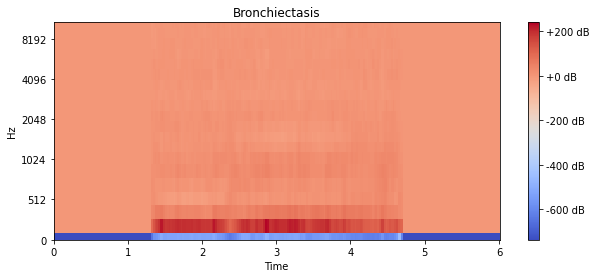

In [38]:
# Visualizing Bronchiectasis
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[5000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiectasis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[5200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiectasis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[5400]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiectasis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[5600]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiectasis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[5800]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiectasis")
matplotlib.pyplot.show()

In [69]:
# Creating an MFCC Directory
os.mkdir("/content/Augmented_MFCC_Train")

In [70]:
# Creating MFCC Sub-Directories For Each Class
os.mkdir("/content/Augmented_MFCC_Train/Bronchiectasis")
os.mkdir("/content/Augmented_MFCC_Train/Bronchiolitis")
os.mkdir("/content/Augmented_MFCC_Train/COPD")
os.mkdir("/content/Augmented_MFCC_Train/Healthy")
os.mkdir("/content/Augmented_MFCC_Train/Pneumonia")
os.mkdir("/content/Augmented_MFCC_Train/URTI")

In [95]:
# Augmenting Training Data With Speed Variation
for index, row in tqdm(training_dataset.iterrows()):
  audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + row["Filename"]) 
  sample_length = len(audio)
  augment_choice = random.choice(["Slow down", "Speed up"])
  if augment_choice == "Slow down":
    augmented_audio = librosa.effects.time_stretch(audio, random.uniform(0.3, 0.8))
    if len(augmented_audio) > sample_length:
      pure_augmented_audio = librosa.effects.trim(augmented_audio)[0]
      if len(pure_augmented_audio) > sample_length:
        augmented_audio = pure_augmented_audio[:sample_length]
      elif len(pure_augmented_audio) < sample_length:
        distance = sample_length - len(pure_augmented_audio)
        augmented_audio = numpy.pad(pure_augmented_audio, (distance//2, distance//2), "constant")
  if augment_choice == "Speed up":
    augmented_audio = librosa.effects.time_stretch(audio, random.uniform(1.5, 3))
    if len(augmented_audio) < sample_length:
      distance = sample_length - len(augmented_audio)
      augmented_audio = numpy.pad(augmented_audio, (0, distance), "constant")
  if len(augmented_audio) == sample_length:
    mfcc = librosa.feature.mfcc(y = augmented_audio, sr = sample_rate)
    matplotlib.pyplot.figure(figsize = (10, 4)) 
    display.specshow(mfcc) 
    filename_dupes = []
    for filename in os.listdir("/content/Augmented_MFCC_Train/" + row["Diagnosis"]):
      if row["Filename"][:-4] in filename:
        filename_dupes.append(filename)
    reappear_number = len(filename_dupes)
    if reappear_number == 0:
      matplotlib.pyplot.savefig("/content/Augmented_MFCC_Train/" + row["Diagnosis"] + "/" +  row["Filename"].replace(".wav", ".png"), bbox_inches = "tight", pad_inches = 0)
      matplotlib.pyplot.close()
    if reappear_number > 0:
      matplotlib.pyplot.savefig("/content/Augmented_MFCC_Train/" + row["Diagnosis"] + "/" +  row["Filename"].replace(".wav", "") + "_count:{}".format(reappear_number) + ".png", bbox_inches = "tight", pad_inches = 0)
      matplotlib.pyplot.close()
  else:
    raise Exception()

In [96]:
print(len(os.listdir("/content/Augmented_MFCC_Train/COPD")))
print(len(os.listdir("/content/Augmented_MFCC_Train/Healthy")))
print(len(os.listdir("/content/Augmented_MFCC_Train/Pneumonia")))
print(len(os.listdir("/content/Augmented_MFCC_Train/URTI")))
print(len(os.listdir("/content/Augmented_MFCC_Train/Bronchiectasis")))
print(len(os.listdir("/content/Augmented_MFCC_Train/Bronchiolitis")))

1000
1000
1000
1000
1000
1000


In [42]:
# Creating an MFCC Test Directory
os.mkdir("/content/MFCC_Test")

In [43]:
# Creating MFCC Test Sub-Directories For Each Class
os.mkdir("/content/MFCC_Test/Bronchiectasis")
os.mkdir("/content/MFCC_Test/Bronchiolitis")
os.mkdir("/content/MFCC_Test/COPD")
os.mkdir("/content/MFCC_Test/Healthy")
os.mkdir("/content/MFCC_Test/Pneumonia")
os.mkdir("/content/MFCC_Test/URTI")

In [44]:
# Resampling The Testing Dataset 
copd_samples = testing_dataset[testing_dataset["Diagnosis"] == "COPD"]
healthy_samples = testing_dataset[testing_dataset["Diagnosis"] == "Healthy"]
pneumonia_samples = testing_dataset[testing_dataset["Diagnosis"] == "Pneumonia"] 
urti_samples = testing_dataset[testing_dataset["Diagnosis"] == "URTI"]  
bronchiolitis_samples = testing_dataset[testing_dataset["Diagnosis"] == "Bronchiolitis"]
bronchiectasis_samples = testing_dataset[testing_dataset["Diagnosis"] == "Bronchiectasis"]

testing_dataset = pandas.concat([copd_samples, healthy_samples, pneumonia_samples, urti_samples, bronchiolitis_samples, bronchiectasis_samples])

In [45]:
for index, row in tqdm(testing_dataset.iterrows()):
  audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + row["Filename"]) 
  mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
  matplotlib.pyplot.figure(figsize = (10, 4)) 
  display.specshow(mfcc)
  matplotlib.pyplot.savefig("/content/MFCC_Test/" + row["Diagnosis"] + "/" +  row["Filename"].replace(".wav", ".png"), bbox_inches = "tight", pad_inches = 0)
  matplotlib.pyplot.close()

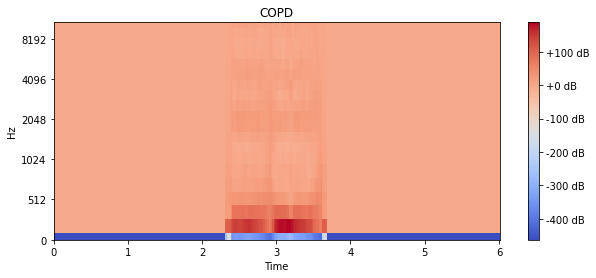

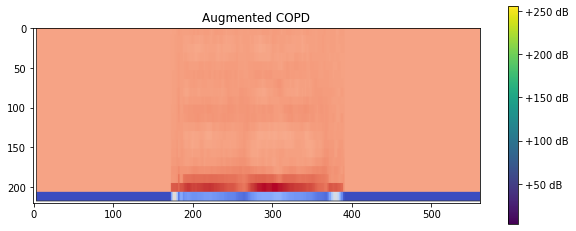

In [121]:
# Visualizing Augmented COPD 
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[500]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("COPD")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
image = PIL.Image.open("/content/Augmented_MFCC_Train/COPD/" + training_dataset.iloc[500]["Filename"].replace(".wav", ".png"))
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Augmented COPD")
matplotlib.pyplot.show()

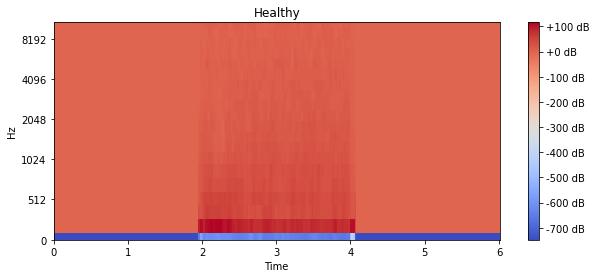

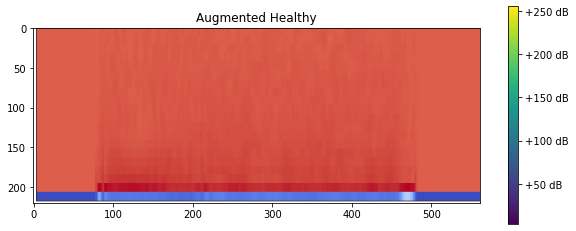

In [101]:
# Visualizing Augmented Healthy
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[1200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Healthy")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
image = PIL.Image.open("/content/Augmented_MFCC_Train/Healthy/" + training_dataset.iloc[1200]["Filename"].replace(".wav", ".png"))
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Augmented Healthy")
matplotlib.pyplot.show()

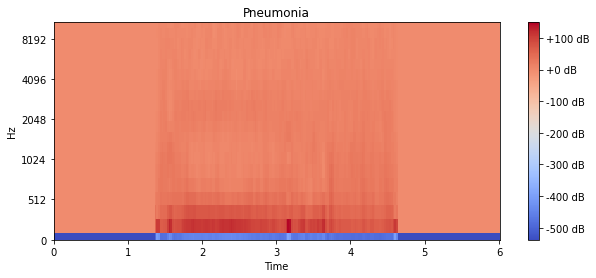

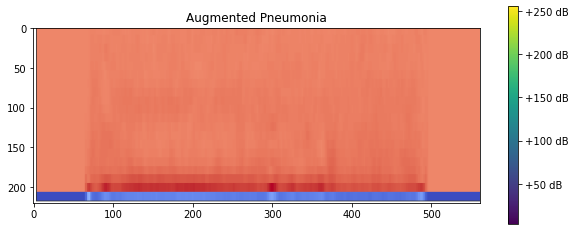

In [118]:
# Visualizing Augmented Pneumonia
matplotlib.pyplot.figure(figsize = (10, 4))
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[2000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Pneumonia")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
image = PIL.Image.open("/content/Augmented_MFCC_Train/Pneumonia/" + training_dataset.iloc[2000]["Filename"].replace(".wav", "") + "_count:3.png")
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Augmented Pneumonia")
matplotlib.pyplot.show()

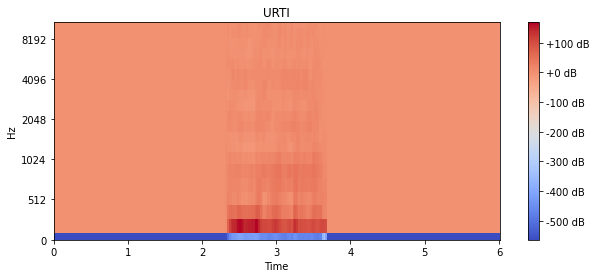

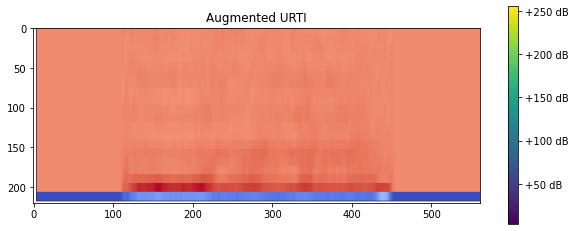

In [115]:
# Visualizing Augmented URTI
matplotlib.pyplot.figure(figsize = (10, 4)) 
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[3000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("URTI")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
image = PIL.Image.open("/content/Augmented_MFCC_Train/URTI/" + training_dataset.iloc[3000]["Filename"].replace(".wav", "") + "_count:1.png")
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Augmented URTI")
matplotlib.pyplot.show()

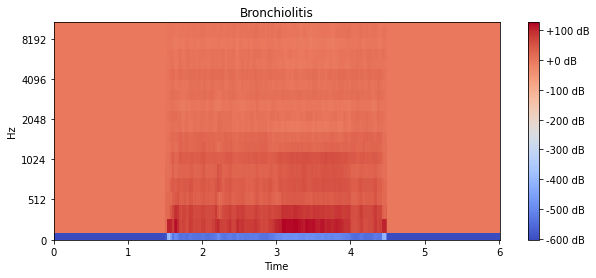

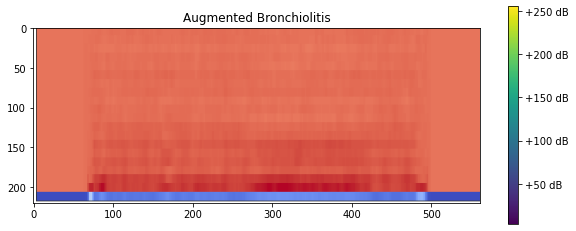

In [114]:
# Visualizing Augmented URTI
matplotlib.pyplot.figure(figsize = (10, 4)) 
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[4200]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiolitis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
image = PIL.Image.open("/content/Augmented_MFCC_Train/Bronchiolitis/" + training_dataset.iloc[4200]["Filename"].replace(".wav", ".png"))
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Augmented Bronchiolitis")
matplotlib.pyplot.show()

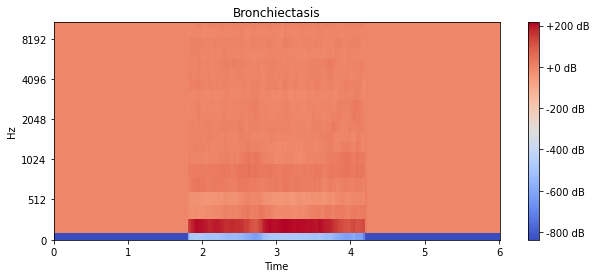

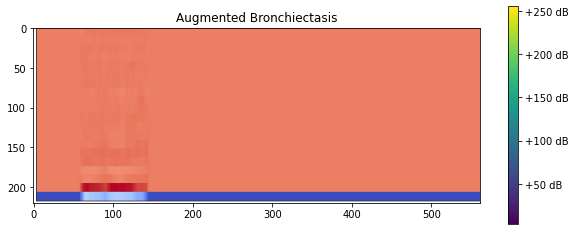

In [122]:
# Visualizing Augmented Bronchiectasis
matplotlib.pyplot.figure(figsize = (10, 4)) 
audio, sample_rate = librosa.load("/content/Processed_Audio_Files/" + training_dataset.iloc[5000]["Filename"])
mfcc = librosa.feature.mfcc(y = audio, sr = sample_rate)
display.specshow(mfcc, x_axis = "time", y_axis = "mel") 
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Bronchiectasis")
matplotlib.pyplot.show()

matplotlib.pyplot.figure(figsize = (10, 4))
image = PIL.Image.open("/content/Augmented_MFCC_Train/Bronchiectasis/" + training_dataset.iloc[5000]["Filename"].replace(".wav", ".png"))
matplotlib.pyplot.imshow(image)
matplotlib.pyplot.colorbar(format='%+2.0f dB')
matplotlib.pyplot.title("Augmented Bronchiectasis")
matplotlib.pyplot.show()

In [3]:
os.mkdir("/content/Augmented_MFCC_Train")

In [5]:
with zipfile.ZipFile("/content/drive/MyDrive/Augmented_MFCC_Train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Augmented_MFCC_Train")

In [6]:
# Initializing ImageDataGenerator
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
                  rescale = 1./255
)
training_image_generator = image_generator.flow_from_directory(directory = "/content/Augmented_MFCC_Train", target_size = (561, 220))

Found 6000 images belonging to 6 classes.


In [7]:
# Initializing MobileNet
mobilenet = tensorflow.keras.applications.mobilenet.MobileNet(input_shape = (561, 220, 3), include_top = False)
mobilenet.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561, 220, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 281, 110, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 281, 110, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 281, 110, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 281, 110, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 281, 110, 32)      128       
_________________________________________________

In [8]:
# Specializing MobileNet for Respiratory Dataset
x = mobilenet.output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(units = 256, activation = "relu")(x)
x = tensorflow.keras.layers.Dense(units = 256, activation = "relu")(x)
predictions = tensorflow.keras.layers.Dense(units = 6, activation = "softmax")(x)

model = tensorflow.keras.models.Model(inputs = mobilenet.input, outputs = predictions)

In [9]:
# Freezing Base Layers
for layer in tqdm(model.layers[:-26]):
  layer.trainable = False

In [10]:
# Compiling Model
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [11]:
# Training Model
model.fit(training_image_generator, epochs = 50, callbacks = tensorflow.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "min", restore_best_weights = True))

Epoch 1/50
188/188 [==============================] - 35s 144ms/step - loss: 6.3572 - accuracy: 0.3692
Epoch 2/50
188/188 [==============================] - 27s 144ms/step - loss: 0.8064 - accuracy: 0.6853
Epoch 3/50
188/188 [==============================] - 27s 144ms/step - loss: 0.5321 - accuracy: 0.7943
Epoch 4/50
188/188 [==============================] - 27s 144ms/step - loss: 0.3809 - accuracy: 0.8540
Epoch 5/50
188/188 [==============================] - 27s 143ms/step - loss: 0.3095 - accuracy: 0.8805
Epoch 6/50
188/188 [==============================] - 27s 146ms/step - loss: 0.2176 - accuracy: 0.9160
Epoch 7/50
188/188 [==============================] - 27s 145ms/step - loss: 0.1686 - accuracy: 0.9413
Epoch 8/50
188/188 [==============================] - 28s 146ms/step - loss: 0.1865 - accuracy: 0.9329
Epoch 9/50
188/188 [==============================] - 27s 145ms/step - loss: 0.1410 - accuracy: 0.9528
Epoch 10/50
188/188 [==============================] - 27s 145ms/step - l

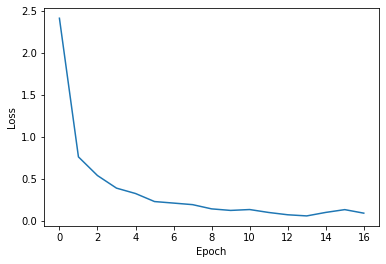

In [12]:
# Visualizing Optimization
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(model.history.epoch, model.history.history["loss"])
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.show()

In [ ]:
# Initializing Testing ImageDataGenerator
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
                  rescale = 1./255
)
testing_image_generator = image_generator.flow_from_directory(directory = "/content/Augmented_MFCC_Test", target_size = (561, 220))

In [46]:
# Initializing Testing Image Generator
testing_image_generator = image_generator.flow_from_directory(directory = "/content/MFCC_Test", target_size = (561, 220))

Found 685 images belonging to 6 classes.


In [49]:
# Examining Testing Accuracy
print("Testing Accuracy: {}%".format(int(model.evaluate(testing_image_generator)[1] * 100)))

22/22 [==============================] - 3s 139ms/step - loss: 0.2929 - accuracy: 0.9401
Testing Accuracy: 94%


In [48]:
# Saving Model
model.save("Respiratory_MobileNet_ISEF_FINAL.h5")